Copyright 2023 Michael Koefinger

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

In [1]:
%matplotlib inline

In [2]:
from __future__ import division
import matplotlib.pyplot as plt
import control as ctr
import dsSim
import numpy as np
import scipy as sc
import deltasigma as ds

/home/michael/tools/miniconda3/envs/ctdsm/lib/python3.10/site-packages/deltasigma-0.2.6-py3.10.egg/deltasigma/_config.py:57: UserWarning: Cannot find the path for 'cblas.h'. You may set it using the environment variable BLAS_H.
NOTE: You need to pass the path to the directories were the header files are, not the path to the files.
  warn("Cannot find the path for 'cblas.h'. You may set it using the environment variable "


# Design Exploration

In [3]:
# Input Data Structure
simInData = {
    "osr": 256,                # oversamping ratio
    "fs": 2**16,               # sampling freq. in Hz
    # Modulator spec
    "mod": {
        "ct": False,           # True: cont. time, False: discrete time
        "ord": 3,              # modulator order
        "k": 1.0,              # gain factor
        "nlev": 2,             # number of quantizer levels
        "optZ": 0,             # optimized zero placement of ntf (0: no, 1: all, 2: only pairs of two)
        "topology": "CIFF",    # DT: "CRFB", "CRFF", "CIFB", "CIFF" or CT: "FF", "FB"
        "scaleStates": False,   # Perform dynamic range scaling
        "OBG": 1.5             # Out of band gain
    },

    # Decimation filter spec
    "dec": {
        "nTaps": 9000,         # FIR filter length, 20*OSR suggested
        "fc": 128,             # corner freq. of FIR
        "window": "hann",      # filter shape, "boxcar", "triangle" see scipy.signal.firwin()
        "movAvg": False, 
        "cascaded": False,
    },

    # Time domain input signal
    "stim": {
        # amplitude vector of sine signal in Volts
        "amplVec_dB": [-1.2],
        "f": 25,               # frequency of sine in Hertz
        "nPeriods": 50,        # length of the stimulus in periods
        "dcOffset": 0,       # DC offset of signal
    }
}

## MOD3 - 1bit - no opt. zeros

In [4]:
tb1 = dsSim.Testbench(simInData)

/home/michael/tools/miniconda3/envs/ctdsm/lib/python3.10/site-packages/scipy-1.11.1-py3.10-linux-x86_64.egg/scipy/signal/_filter_design.py:1746: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  warnings.warn("Badly conditioned filter coefficients (numerator): the "


/home/michael/tools/miniconda3/envs/ctdsm/lib/python3.10/site-packages/deltasigma-0.2.6-py3.10.egg/deltasigma/_simulateDSM.py:216: UserWarning: Using a slow implementation of simulateDSM
Refer to the docs for how to switch to a fast one
  warn('Using a slow implementation of simulateDSM\n' +


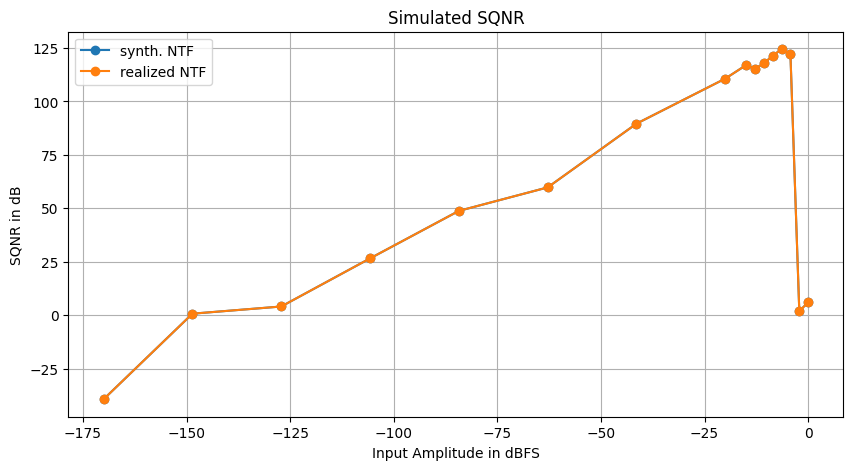

In [5]:
tb1.plotSNR()

# MOD3 - 1bit - opt. zeros

In [6]:
simInData['mod']['optZ'] = 2
tb2 = dsSim.Testbench(simInData)

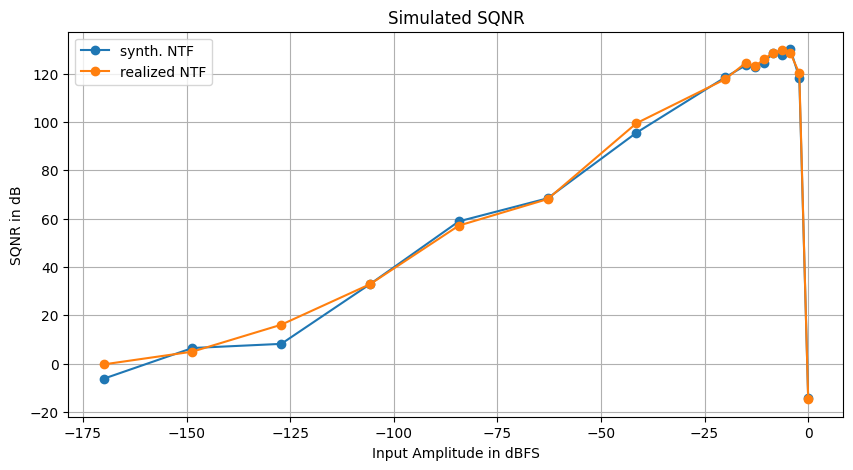

In [7]:
tb2.plotSNR()

## MOD4 - 1bit - no opt. zeros

In [8]:
simInData['mod']['optZ'] = 0
simInData['mod']['ord'] = 4
tb3 = dsSim.Testbench(simInData, interpOsr=16)

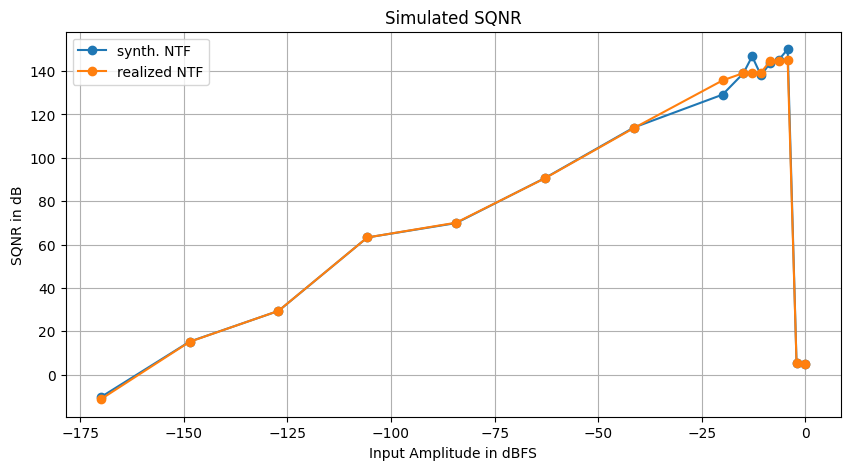

In [9]:
tb3.plotSNR()

## MOD4 - 1bit - opt zeros

In [10]:
simInData['mod']['optZ'] = 2
simInData['mod']['ord'] = 4
tb4 = dsSim.Testbench(simInData)

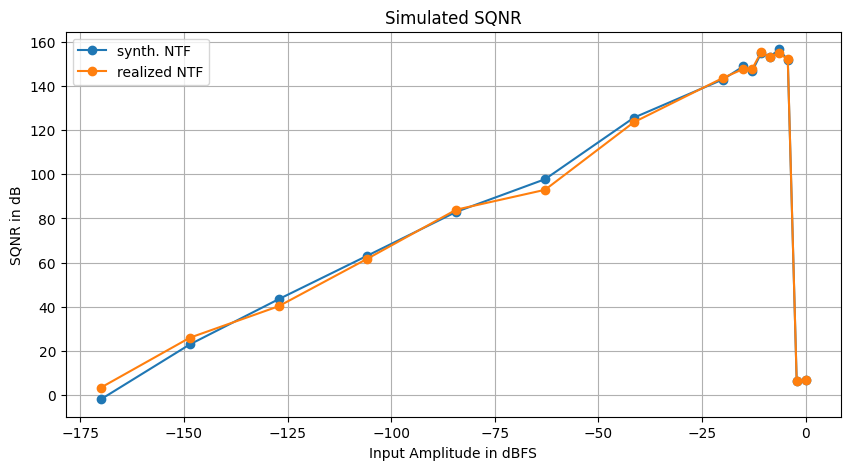

In [11]:
tb4.plotSNR()

## MOD5 - 1bit - no opt zeros

In [12]:
simInData['mod']['optZ'] = 0
simInData['mod']['ord'] = 5
tb5 = dsSim.Testbench(simInData)

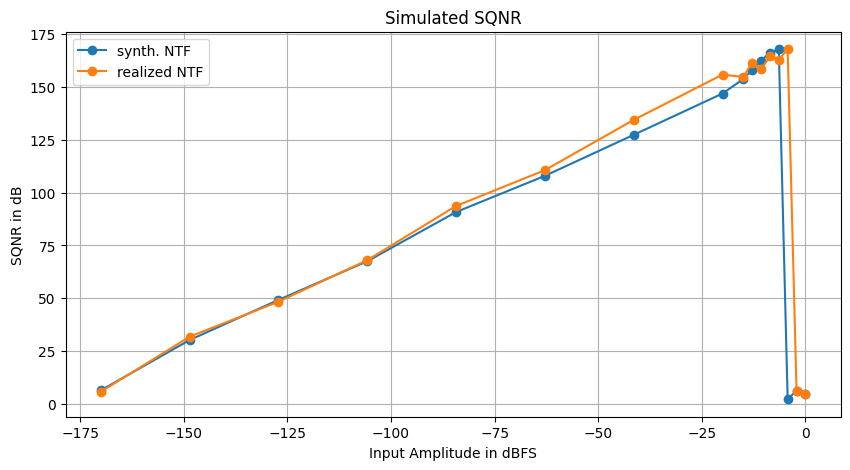

In [13]:
tb5.plotSNR()

## Export Data

In [14]:
data_mod3noptz= tb1.getSNRPlotData()['synth'][1]
data_mod3optz = tb2.getSNRPlotData()['synth'][1]
data_mod4noptz = tb3.getSNRPlotData()['synth'][1]
data_mod4optz = tb4.getSNRPlotData()['synth'][1]
data_mod5noptz = tb5.getSNRPlotData()['synth'][1]
inputVec = tb1.getSNRPlotData()['synth'][0]
np.savetxt('explore.txt', np.column_stack([inputVec, data_mod3noptz, data_mod3optz, data_mod4noptz, data_mod4optz, data_mod5noptz]), header='input sqnr1 sqnr2 sqnr3 sqnr4 sqnr5', comments='')

In [15]:
peak_snrR_mod3noptz, peak_ampR_mod3noptz = ds.peakSNR(data_mod3noptz, inputVec)
peak_snrR_mod3optz, peak_ampR_mod3optz = ds.peakSNR(data_mod3optz, inputVec)
peak_snrR_mod4noptz, peak_ampR_mod4noptz = ds.peakSNR(data_mod4noptz, inputVec)
peak_snrR_mod4optz, peak_ampR_mod4optz = ds.peakSNR(data_mod4optz, inputVec)
#peak_snrR_mod5noptz, peak_ampR_mod5noptz = ds.peakSNR(data_mod5noptz, inputVec)

/home/michael/tools/miniconda3/envs/ctdsm/lib/python3.10/site-packages/deltasigma-0.2.6-py3.10.egg/deltasigma/_peakSNR.py:85: RuntimeWarning: invalid value encountered in sqrt
  peak_amp = c - np.sqrt(ab[1, 0]/ab[0, 0])


## NTF of 4th order DSM

In [16]:
print('MSA = {0}'.format(peak_ampR_mod4noptz)+" dBFS")
print('peak SQNR = {0}'.format(np.squeeze(peak_snrR_mod4noptz))+" dB")
MSA_scaled = 20*np.log10(tb3.getModulatorObj().getMSI())
print('MSA after dyn. range scaling: {0}'.format(MSA_scaled)+" dBFS")

MSA = nan dBFS
peak SQNR = nan dB


AttributeError: 'Modulator' object has no attribute '_msi'

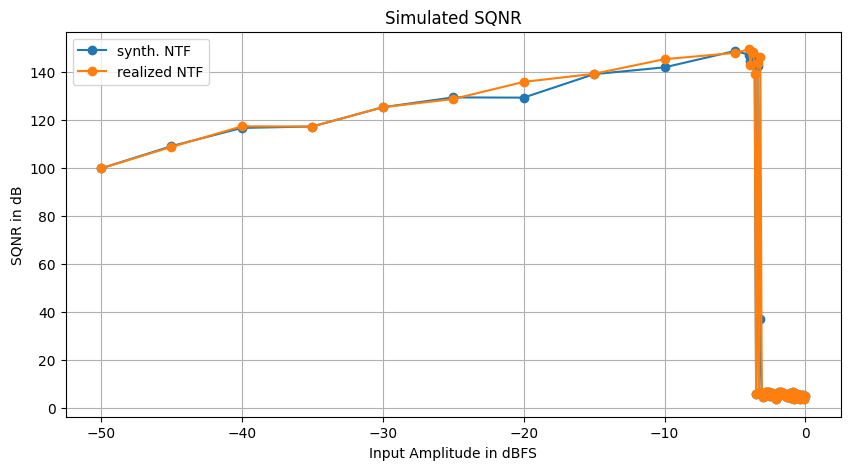

In [17]:
tb3.plotSNR([-50, -5, 5], [-4, 0, 0.1])

In [19]:
indBFS = tb3.getSNRPlotData()['synth'][0]
sqnr_synth = tb3.getSNRPlotData()['synth'][1]
sqnr_real = tb3.getSNRPlotData()['real'][1]
peak_snr_synth, peak_amp_synth = ds.peakSNR(sqnr_synth, indBFS)
#peak_snr_real, peak_amp_real = ds.peakSNR(sqnr_real, indBFS)
print('Synth. MSA = {0}'.format(peak_amp_synth)+" dBFS")
print('Synth. peak SQNR = {0}'.format(np.squeeze(peak_snr_synth))+" dB")
#print('Real. MSA = {0}'.format(peak_amp_real)+" dBFS")
#print('Real. peak SQNR = {0}'.format(np.squeeze(peak_snr_real))+" dB")

Synth. MSA = -4.369957864659453 dBFS
Synth. peak SQNR = 147.45729701556715 dB


## ds.peakSNR did not yield a result --> check vectors manually

In [ ]:
print('Synth. MSA = -1.2')
print('Synth. peak SQNR = 148.4 dB')

## Export detailed SQNR plot

In [ ]:
tb3.exportSNRPlotData('sqnr_mod4_detailed.txt')

In [ ]:
ntf = tb3.getModulatorObj().getSynthNTF()
print(ds.pretty_lti(ntf))

In [ ]:
ds.plotPZ(ntf)

## Time domain sim of chosen architecture

In [ ]:
tb3.run(singleRun=False, useNTF=True)

In [ ]:
tb3.plotResult(zoomXY=(True, True), zoomFactY=0.2e-1, show={"in": (True, True), "out": (True, True, False)})
tb3.getStimulusObj().plotStim()

In [ ]:
tb3.exportDecimatedSignals('sim_neg1_2dBFS_0vdc_25Hz.txt', tStartRel = 0.45, tStopRel=0.55)

In [ ]:
nomInputSig = dsSim.TdSimStimulus([-31.1, -97.1], 25, 2.08, simInData['fs'], simInData['osr'], 4, nPeriods=50)
tb3.setStimulusObj(nomInputSig)
tb3.run(singleRun=False, useNTF=True)

In [ ]:
tb3.plotResult(zoomXY=(True, True), zoomFactY=0.02e-2, show={"in": (True, True), "out": (True, True, False)})
tb3.getStimulusObj().plotStim()

In [ ]:
tb3.exportDecimatedSignals('sim_neg31_1dBFS_250mvdc_25Hz.txt', tStartRel = 0.45, tStopRel=0.55)
#tb3.exportDecimatedSignals('sim_neg97_1dBFS_250mvdc_25Hz.txt', tStartRel = 0.45, tStopRel=0.55)

## Frequency domain sim of chosen arch.

In [ ]:
psdInputSig = dsSim.FdSimStimulus([-3.37], 25/simInData['fs'], 0, 1, simInData['osr'], 4, N_FFT=2**20)
tb3.setStimulusObj(psdInputSig)

In [ ]:
tb3.run(singleRun=False, useNTF=True)
tb3.calcPSDParam()

In [ ]:
tb3.simulateSNRWrapper()


## Sweep input frequency and evaluate SQNR, find worst SQNR

In [20]:
finVec = np.r_[12:30:1]/simInData['fs']
snrVec = []
for i in range(len(finVec)):
    res = tb3.simulateSNRWrapper(finVec[i], useNTF=True)
    snrVec.append(res)

plt.figure()
plt.plot(finVec*simInData['fs'], snrVec)


/home/michael/tools/miniconda3/envs/ctdsm/lib/python3.10/site-packages/deltasigma-0.2.6-py3.10.egg/deltasigma/_simulateSNR.py:217: UserWarning: Increasing k to accommodate a low input frequency.
  warn('Increasing k to accommodate a low input frequency.')


KeyboardInterrupt: 

## Plot and export PSD data

In [ ]:
tb3.plotPSD()
tb3.exportPSDPlotData('psd_explore.txt')

## Use python-deltasigma toolbox function to plot smoothed spectrum

This should yield same result as above

In [ ]:
ds.plotSpectrum(tb3.getPSD()['PSD'][0], int(tb3.getStimulusObj().getStimFreq()*tb3.getStimulusObj().getSampleCnt()))

## Verify Out of Band Gain (OBG)

In [ ]:
res = tb3.verifyOBG()
print("Simulated OBG = {0}".format(res[0]))
print("Synth. OBG = {0}".format(res[1]))


## CT Loop Filter Coeff - FF

In [ ]:
simInData['mod']['ct'] = True
simInData['mod']['topology'] = 'FF'
ctff = dsSim.Testbench(simInData)
ABCD = ctff.getModulatorObj().getStateSpaceMat()
print(ABCD)


## CT Loop Filter Coeff - FB

In [ ]:
simInData['mod']['ct'] = True
simInData['mod']['topology'] = 'FB'
ctfb = dsSim.Testbench(simInData)
ABCD = ctfb.getModulatorObj().getStateSpaceMat()
print(ABCD)